<a href="https://colab.research.google.com/github/PunitRaveendran/ACM/blob/main/Day-2%20Feature%20Forge%20%2B%20Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv("/content/mental_health_workplace_survey.csv")


#Day 1


In [ ]:
df.isnull()
df.isnull().sum()
#isnull will show true for the blocks that are missing values and isnull().sum() will will show how many are missing

,0
EmployeeID,0
Age,0
Gender,0
Country,0
JobRole,0
Department,0
YearsAtCompany,0
WorkHoursPerWeek,0
RemoteWork,0
BurnoutLevel,0


Enter the column name: WorkHoursPerWeek


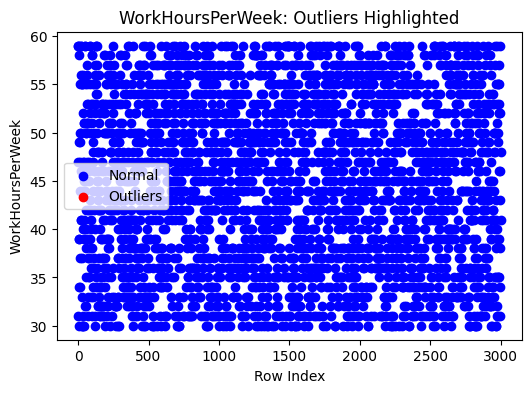

In [5]:
#user defined function to find the outliers in that particular column entered with refernce to index
def OutlierVal():
    col = input("Enter the column name: ")
    if col not in df.columns:
        print(" Column not found in dataset.")
        return
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    #to find the outliers by inter quartile range

    # Boolean mask for outliers
    mask_outliers = (df[col] < lower_bound) | (df[col] > upper_bound)

    # Plot
    plt.figure(figsize=(6,4))
    plt.scatter(df.index, df[col], color='blue',label='Normal')
    plt.scatter(df.index[mask_outliers], df[col][mask_outliers],color='red', label='Outliers')
    plt.title(f"{col}: Outliers Highlighted")
    plt.xlabel("Row Index")
    plt.ylabel(col)
    plt.legend()
    plt.show()
OutlierVal()

/tmp/ipython-input-18-1596971756.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_stress = df.groupby('SleepGroup')['StressLevel'].mean().reset_index()
/tmp/ipython-input-18-1596971756.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_stress, x='SleepGroup', y='StressLevel', palette='viridis')


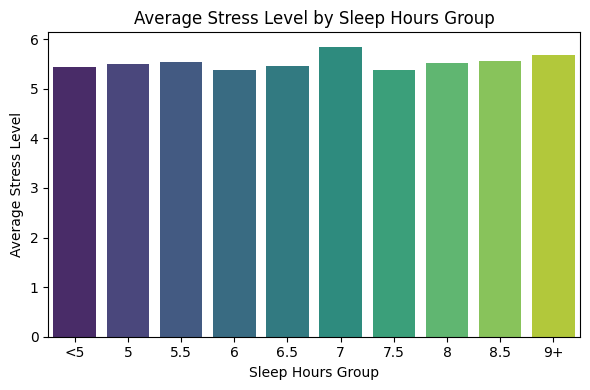

In [ ]:
bins = [0,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5]
labels = ['<5','5','5.5','6','6.5','7','7.5','8','8.5','9+']
df['SleepGroup'] = pd.cut(df['SleepHours'], bins=bins, labels=labels, right=False)
avg_stress = df.groupby('SleepGroup')['StressLevel'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(6,4))
sns.barplot(data=avg_stress, x='SleepGroup', y='StressLevel', palette='viridis')
plt.title('Average Stress Level by Sleep Hours Group')
plt.xlabel('Sleep Hours Group')
plt.ylabel('Average Stress Level')
plt.tight_layout()
plt.show()

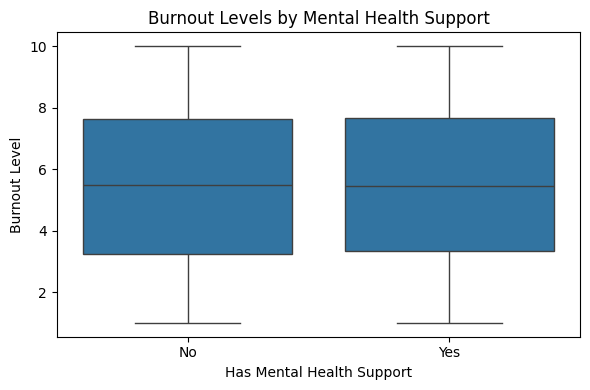

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="HasMentalHealthSupport", y="BurnoutLevel")
plt.title('Burnout Levels by Mental Health Support')
plt.xlabel('Has Mental Health Support')
plt.ylabel('Burnout Level')
plt.tight_layout()
plt.show()

# Day 2


In [12]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression as mi_regression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Load the dataframe
df=pd.read_csv("/content/mental_health_workplace_survey.csv")

base_cat= "StressLevel"
y=df[base_cat]

# we seperate numerical and categorical columns
num_cols = df.select_dtypes(include=[np.number]).drop(columns=[base_cat]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

#creating the interactions
if "WorkHoursPerWeek" in df.columns and "StressLevel" in df.columns:
  df["stress_work_interaction"] = df["WorkHoursPerWeek"] * df ["StressLevel"]
  num_cols.append("stress_work_interaction")
if "SleepHours" in df.columns and "StressLevel" in df.columns:
  df["stress_sleep_interaction"] = df["SleepHours"] * df ["StressLevel"]
  num_cols.append("stress_sleep_interaction")


#Feature selection using correlation
#Correlation
'''corr_matrix = df[num_cols + [base_cat]].corr()
corr_with_target = corr_matrix[base_cat].sort_values(ascending=False)
print("Correlation with target:")
print(corr_with_target)'''

#Correlation only has linear MI has non linear also so prefering this
#Feature selection using mutual information
X_for_all = df[num_cols + cat_cols]
X_in_temp = pd.get_dummies(X_for_all, columns = cat_cols, drop_first = True)
mutual_info = mi_regression(X_in_temp, y)
mutual_info_series = pd.Series(mutual_info, index= X_in_temp.columns)
features_selected = mutual_info_series.sort_values(ascending=False).head(10).index.tolist()

print("Features selected based on mutual information:")
print(features_selected)

#Preprocessing pipelines
cat_selected = [c for c in cat_cols if c in features_selected]
num_selected = [c for c in num_cols if c in features_selected]


# on hot encoder for category and scaler for numerical
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_selected),
        ('num', StandardScaler(), num_selected)
    ],
    remainder='passthrough') # Keep other columns

#split
X= df[cat_selected + num_selected]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

#Train model
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha = 1.0),
    "Lasso": Lasso(alpha = 0.01, max_iter=10000)
}
results = {}

for name ,model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R2": r2}
    print(f"{name} - MSE: {mse:.3f}, R²: {r2:.3f}")

#Conclusion
bestmodel = max(results, key = lambda x: results[x]["R2"])
print("Conclusion")
for m,v in results.items():
    print(f"{m} - MSE: {v['MSE']:.3f}, R²: {v['R2']:.3f}")
print(f"Best model : {bestmodel} with R² = {results[bestmodel]['R2']:.3f}")
print("This is because it achieved the highest R² (explained variance) and lowest MSE among the three.")

#If the R² value is closer to 1 it means that the predicted values are more accurate thereby making it a better model
#If the MSE value is closer to 0 it means that the variance error between the predicted values is low making it a good model

Features selected based on mutual information:
['stress_work_interaction', 'stress_sleep_interaction', 'Country_Germany', 'SleepHours', 'CareerGrowthScore', 'Department_IT', 'ManagerSupportScore', 'HasTherapyAccess_Yes', 'YearsAtCompany', 'JobRole_Marketing Manager']
Linear Regression - MSE: 0.279, R²: 0.960
Ridge - MSE: 0.279, R²: 0.960
Lasso - MSE: 0.278, R²: 0.960
Conclusion
Linear Regression - MSE: 0.279, R²: 0.960
Ridge - MSE: 0.279, R²: 0.960
Lasso - MSE: 0.278, R²: 0.960
Best model : Lasso with R² = 0.960
This is because it achieved the highest R² (explained variance) and lowest MSE among the three.
